In [232]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [246]:
# Definir rutas
ROOT_PATH = './data/images/'
TRAIN_PATH = ROOT_PATH + "train/"
TEST_PATH = ROOT_PATH + "test/"

# Leer los archivos CSV
train_csv_path = 'train_set.csv'
test_csv_path = 'test_set.csv'
sample_submission_path = 'sample_submision.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [247]:
# Para modificar la ruta para mac

def replace_backslash(path):
    return path.replace('\\', '/')

# Aplicar la función a la columna 'path'
train_df['path'] = train_df['path'].apply(replace_backslash)

In [248]:

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])


In [249]:
def read_train_data(dataframe, reshape_dim=(64, 64)):
    X = []
    y = []
    for index, row in dataframe.iterrows():
        img_path = os.path.join(ROOT_PATH, row['path'].replace('../data/images/', ''))
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
        if image is not None:
            image = cv2.resize(image, reshape_dim)  # Redimensionar a 64x64
            X.append(image)
            y.append(row['label'])
    
    X = np.array(X).reshape(-1, reshape_dim[0], reshape_dim[1], 1)
    y = np.array(y)
    return X, y

def read_test_data(dataframe, reshape_dim=(64, 64)):
    X = []
    for index, row in dataframe.iterrows():
        img_path = os.path.join(TEST_PATH, f"{row['id_img']}.jpg")
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
        if image is not None:
            image = cv2.resize(image, reshape_dim)  # Redimensionar a 64x64
            X.append(image)
    
    X = np.array(X).reshape(-1, reshape_dim[0], reshape_dim[1], 1)
    return X

In [250]:
# Cargar datos de entrenamiento y prueba
X_train, y_train = read_train_data(train_df)
X_test = read_test_data(test_df)

In [251]:
# Normalización
X_train = X_train / 255.0
X_test = X_test / 255.0

In [252]:
# Asignar números a emociones
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

In [253]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

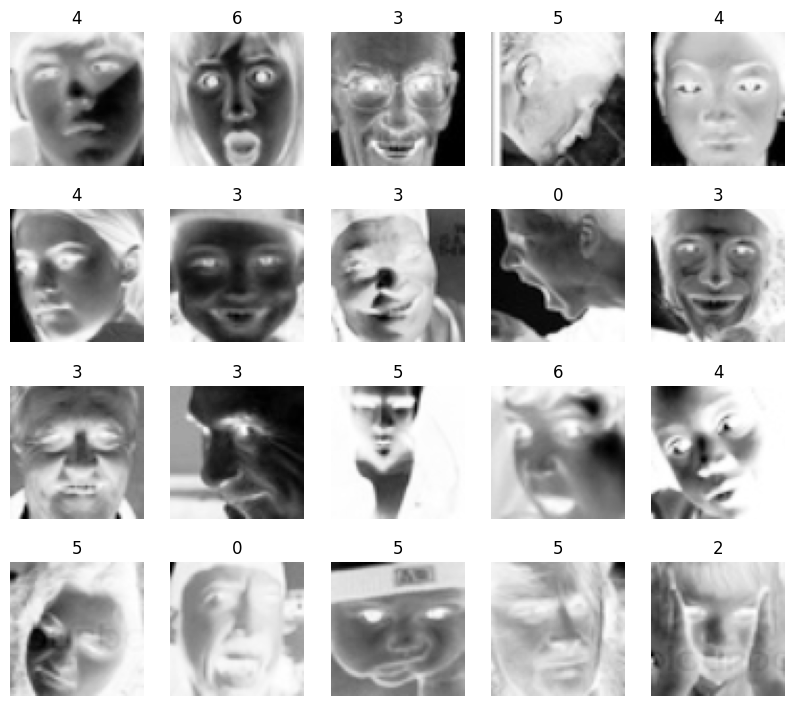

In [254]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [259]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compilar el modelo con un optimizador ajustado
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_228 (Conv2D)             │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_227         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_228         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_131               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_229         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_230         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_132               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_231         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_233 (Conv2D)             │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_232         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_234 (Conv2D)             │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_233         │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 14,138,311 (53.93 MB)

 Trainable params: 14,134,471 (53.92 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [260]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')]

In [261]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 720
Batch_size: 64, num_steps_per_epoch: 360
Batch_size: 96, num_steps_per_epoch: 240
Batch_size: 128, num_steps_per_epoch: 180


In [262]:
history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.1920 - loss: 18.0689 - val_accuracy: 0.2189 - val_loss: 16.6522
Epoch 2/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.2297 - loss: 15.7720 - val_accuracy: 0.2592 - val_loss: 14.5582
Epoch 3/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.2465 - loss: 13.8984 - val_accuracy: 0.2977 - val_loss: 12.5379
Epoch 4/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.2849 - loss: 11.9615 - val_accuracy: 0.3707 - val_loss: 10.4758
Epoch 5/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.3201 - loss: 10.1540 - val_accuracy: 0.3884 - val_loss: 8.8496
Epoch 6/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.3558 - loss: 8.5467 - val_accuracy: 0.3799 - val_loss: 7.4456
Epoch 7/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.3827 - loss: 7.1652 - val_accuracy: 0.4340 - val_loss: 6.1983
Epoch 8/75
361/361 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.4013 - loss: 6.0172 -

In [263]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

221/221 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step


In [264]:
submission_df = pd.DataFrame({
    'id_img': test_df['id_img'],
    'label': label_encoder.inverse_transform(predictions)
})

In [265]:
submission_df.to_csv('submission6.csv', index=False)

# Verificar el contenido del archivo de submission
print(submission_df.head())

   id_img  label
0   10052    sad
1   10065   fear
2   10079  angry
3   10095    sad
4   10121  angry


In [266]:
model.save('modelo_entrenado.keras')